Author: Cristian F. Zapata 

Email: cfzapatag@uqvirtual.edu.co

Description: This notebook makes a quantum mapping of a features vector  to then be represented in a photonic circuit through variational coding. This circuit is part of a photonic neural network based on probability density estimation.



## QFM for targetX

In [1]:
import numpy as np

class QuantumFMap:
    """
    Attributes:
        cutoff_dim (int): The cutoff dimension for sf simulation.
        modes (int): The number of modes in the photonic circuit.
        vals (list): A list of values used to QFM.
        r (float): Squeezing parameter for the squeezed states.
        Squeezed_QFM (numpy.ndarray): QFM using squeezed states.

    Methods:
        __init__(self, cutoff_dim, modes, vals, r):
            Initializes a QuantumFMap instance with the specified parameters.

        Squeezed_QFM(self):
            Calculates the QFM with squeezed states based on the given parameters.
    """
    def __init__(self, cutoff_dim, modes, vals,r):
        self.cutoff_dim = cutoff_dim
        self.modes = modes
        self.vals = vals
        self.r=r
        self.Squeezed_QFM = self.Squeezed_QFM()

    def Squeezed_QFM(self):
        """
        This function converts a list with data into QFM.
         The cutoff dimension depends on the cutoff_dim of the sf simulation
          and the number of modes used to make the VQFM
          
          Returns:
            numpy.ndarray: Quantum Frequency Map with squeezed states.
        """
        QFM1 = []
        for val in self.vals:
            target_state = []
            for n in range(self.cutoff_dim ** self.modes):
                coeff = (
                    (1 / np.sqrt(np.cosh(r)))
                    * (np.sqrt(np.math.factorial(2 * n)))
                    / ((2 ** n) * np.math.factorial(n))
                    * (np.tanh(r) * np.exp((-1) ** (1 / 2) * (val*np.pi + np.pi))) ** n
                )
                target_state.append(coeff)
            QFM1.append(target_state)

        return np.array(QFM1)


#input

cutoff_dim = 3
modes = 2
r=0.5
vals = [0.2, 0.5, 0.3, 0.2, 0.5, 0.3] #features for QFM

# normalize data
mini = np.min(vals)
maxi = np.max(vals)
vals = (vals - mini) / (maxi - mini)

quantum_state = QuantumFMap(cutoff_dim, modes, vals,r)
QFM=quantum_state.Squeezed_QFM
QFM

array([[ 9.41710616e-01+0.00000000e+00j, -3.07719176e-01+3.76847304e-17j,
         1.23150814e-01-3.01632500e-17j, -5.19515795e-02+1.90867007e-17j,
         2.24571622e-02-1.10008367e-17j, -9.84528344e-03+6.02849743e-18j,
         4.35598160e-03-3.20072335e-18j, -1.93975012e-03+1.66285614e-18j,
         8.67927640e-04-8.50323845e-19j],
       [ 9.41710616e-01+0.00000000e+00j,  3.07719176e-01-7.53694609e-17j,
         1.23150814e-01-6.03265000e-17j,  5.19515795e-02-3.81734013e-17j,
         2.24571622e-02-2.20016735e-17j,  9.84528344e-03-1.20569949e-17j,
         4.35598160e-03-6.40144671e-18j,  1.93975012e-03-3.32571229e-18j,
         8.67927640e-04-1.70064769e-18j],
       [ 9.41710616e-01+0.00000000e+00j, -1.53859588e-01-2.66492624e-01j,
        -6.15754069e-02+1.06651733e-01j,  5.19515795e-02-8.76685787e-17j,
        -1.12285811e-02-1.94484730e-02j, -4.92264172e-03+8.52626557e-03j,
         4.35598160e-03-1.51299797e-17j, -9.69875061e-04-1.67987288e-03j,
        -4.33963820e-04+7.51

## Circuit

In [2]:
import numpy as np
import os
import strawberryfields as sf
from strawberryfields import ops
import tensorflow as tf
import warnings
from itertools import combinations
warnings.filterwarnings("ignore")
physical_devices = tf.config.experimental.list_physical_devices('CPU')
tf.config.experimental.set_visible_devices(physical_devices[0])

def init_weights(modes, layers, active_sd=0.1, passive_sd=1):
    """
    Initializes weights for QNN.

    This function generates random weights for the parameters of a quantum neural network
    with specified modes and layers.

    Args:
        modes (int): Number of modes in the photonic circuit.
        layers (int): Number of layers in the QNN.
        active_sd (float, optional): Standard deviation for weights of active parameters.
            Defaults to 0.1.
        passive_sd (float, optional): Standard deviation for weights of passive parameters.
            Defaults to 1.

    Returns:
        tf.Variable: TensorFlow Variable containing the initialized weights.

    """
    # Number of interferometer parameters:
    M = int(modes * (modes - 1)) 
    # TensorFlow variables
    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    r1_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_mag_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    s_phase_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    r2_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    r3_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    r4_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, r1_weights, s_mag_weights,s_phase_weights, int2_weights, 
                         r2_weights, r3_weights, r4_weights, k_weights], axis=1)
    weights = tf.Variable(weights)
    return weights



def input_qnn_layer(hid,q):
    """
    Applies an input layer to a quantum neural network.

    This function introduces data to the QNN by applying a sequence
    of quantum gates to the input qumode.

    Args:
        hid (list): List of a parameter for the quantum gates in the input layer.

    Returns:
        None
    """
    with tf.name_scope('inputlayer'):
        ops.Rgate(hid[0]) | q[0]
        ops.Rgate(hid[0]) | q[0]       
        ops.Rgate(hid[0]) | q[0]
        
        ops.Rgate(hid[0]) | q[1]
        ops.Rgate(hid[0]) | q[1]       
        ops.Rgate(hid[0]) | q[1]

# Defining standard variational layers
def qnn_layer(params,layer_number,q):
    with tf.name_scope('layer_{}'.format(layer_number)):
        N = len(q)
        M = int(modes * (modes - 1)) 
        
        int1 = params[:M]
        r1=params[M:M+N]
        sm = params[M+N:M+2*N]
        sp = params[M+2*N:M+3*N]
        int2 = params[M+3*N:2*M+3*N]
        r2=params[2*M+3*N:2*M+4*N]
        r3 = params[2*M+4*N:2*M+5*N]
        r4 = params[2*M+5*N:2*M+6*N]

        
        theta1=int1[:len(int1)//2]
        phi1=int1[len(int1)//2:]
        
        theta2=int2[:len(int2)//2]
        phi2=int2[len(int2)//2:]
        
        for k, (q1, q2) in enumerate(combinations(q,2)):
            ops.BSgate(theta1[k], phi1[k]) | (q1, q2)
        for i in range(N):
            ops.Rgate(r1[i]) | q[i]
        for i in range(N):
            ops.Sgate(sm[i],sp[i]) | q[i]
        for k, (q1, q2) in enumerate(combinations(q,2)):
            ops.BSgate(theta2[k], phi2[k]) | (q1, q2)
        for i in range(N):
            ops.Rgate(r2[i]) | q[i]
        for i in range(N):
            ops.Rgate(r3[i]) | q[i]
        for i in range(N):
            ops.Rgate(r4[i]) | q[i]

layers=4
hidden_units=3*modes 

eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
qnn = sf.Program(modes)

# initialize varitional weights
weights = init_weights(modes, layers) #TensorFlow weights
num_params = np.prod(weights.shape)   

sf_params = np.arange(num_params).reshape(weights.shape).astype(str)
sf_params = np.array([qnn.params(*i) for i in sf_params])

hid_params = np.arange(num_params,num_params+hidden_units).reshape(hidden_units,1).astype(str)
hid_params = np.array([qnn.params(*i) for i in hid_params])

with qnn.context as q:
    input_qnn_layer(hid_params,q)
    for k in range(layers):
        qnn_layer(sf_params[k],k, q)

## VQMF

In [3]:
def state_VQFM(x):
    """make vqfm of a data, putting it as a parameter in the encoding layer"""
    """
    Generates a Quantum State using a Variational QFM (VQFM) encoding layer.

    This function takes input data 'x' and evaluate the quantum state by mapping it through
    a Variational circuit.

    Args:
        x (float): Input data to be encoded in the quantum state.

    Returns:
        tf.Tensor: Quantum state represented as a complex-valued tensor.
    """
    mapping_wt = {p.name: w for p, w in zip( sf_params.flatten() , tf.reshape(weights, [-1]))}
    mapping_hid={p.name: w for p, w in zip(hid_params, tf.fill((6,), x) )}
    mapping_wt.update(mapping_hid)
    results = eng.run(qnn, args=mapping_wt)
    ket = results.state.ket()
    ket=tf.reshape(ket, [-1])
    ket=tf.cast(ket, tf.complex128)
    if eng.run_progs:
        eng.reset()
    return ket 
#inicializa
state_VQFM(0.1)

<tf.Tensor: shape=(9,), dtype=complex128, numpy=
array([ 9.51502562e-01-0.00528582j,  0.00000000e+00+0.j        ,
       -4.84396629e-02-0.264128j  ,  0.00000000e+00+0.j        ,
        9.34067555e-03-0.11289831j,  0.00000000e+00+0.j        ,
        5.28320149e-02-0.0264888j ,  0.00000000e+00+0.j        ,
       -5.19030262e-04-0.00244637j])>

## Cost function

In [4]:
def cost(vector_x, QFM):
    """
    Computes the mean infidelity between vectors with data.

    This function vectorizes the calculation of the infidelity between two vectors and
    returns the mean of a vector containing the infidelities between the vectors in the
    lists `vector_x` and `QFM`.

    Args:
        vector_x (tf.Tensor): List of vectors.
        QFM (tf.Tensor): Quantum Features map

    Returns:
        tf.Tensor: Mean infidelity between vectors.

    """

    def vectorized_infidelity(x, qfm):
        VQFM = state_VQFM(x)  
        return cc

    brakets = tf.map_fn(lambda args: vectorized_infidelity(*args), (vector_x, QFM), dtype=tf.complex128)
    return tf.reduce_mean(brakets)

optimizer = tf.keras.optimizers.Adam()


In [ ]:
#mod

def cost(x, qfm):
     
    mapping_wt = {p.name: w for p, w in zip( sf_params.flatten() , tf.reshape(weights, [-1]))}
    mapping_hid={p.name: w for p, w in zip(hid_params, tf.fill((6,), x) )}
    mapping_wt.update(mapping_hid)
    results = eng.run(qnn, args=mapping_wt)
    VQFM = results.state.ket()
    VQFM=tf.reshape(VQFM, [-1])
    VQFM=tf.cast(VQFM, tf.complex128)
    if eng.run_progs:
        eng.reset()
    return tf.cast(1 - tf.abs(tf.reduce_sum(tf.multiply(VQFM, qfm))**2), tf.complex128)

optimizer = tf.keras.optimizers.Adam()


In [5]:
QFM=tf.cast(QFM, tf.complex128)

In [6]:
vals=tf.cast(vals, tf.complex128)

In [ ]:
#mod

def train_1value():
    for i in range(10):
        #modi
        mapping_wt = {p.name: w for p, w in zip( sf_params.flatten() , tf.reshape(weights, [-1]))}


        with tf.GradientTape() as tape:
            loss=cost(vals, QFM)
            
        gradients=tape.gradient(loss,weights)
        optimizer.apply_gradients(zip([gradients],[weights]))
        
        if eng.run_progs:
            eng.reset()
        print("loss at iteration {} is {}".format(i,loss))
        

In [1]:
def my_generator():
    for i in range(5):
        yield i

# Uso del generador
gen = my_generator()

for value in gen:
    print(value)


0
1
2
3
4


## Train

In [7]:

for i in range(10):
    with tf.GradientTape() as tape:
        loss=cost(vals, QFM)
        
    gradients=tape.gradient(loss,weights)
    optimizer.apply_gradients(zip([gradients],[weights]))
    
    if eng.run_progs:
        eng.reset()
    print("loss at iteration {} is {}".format(i,loss))

Cause: Unable to locate the source code of <function state_VQFM at 0x00000175A19A9260>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: source code not available
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function state_VQFM at 0x00000175A19A9260>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: source code not available
To silence this warning, decorate the function w

loss at iteration 0 is (0.18494632059959815+0j)
loss at iteration 1 is (0.18248405638218315+0j)
loss at iteration 2 is (0.18006411139970357+0j)
loss at iteration 3 is (0.1776885306358927+0j)
loss at iteration 4 is (0.17535854839916423+0j)
loss at iteration 5 is (0.17307506729808875+0j)
loss at iteration 6 is (0.17083751192053723+0j)
loss at iteration 7 is (0.16864599592180984+0j)
loss at iteration 8 is (0.166501085942431+0j)
loss at iteration 9 is (0.16440361432167214+0j)


## Weights

In [8]:
f_weights = weights.numpy() 
f_weights

array([[-0.0375486 ,  2.5483966 , -0.649542  , -0.61087865,  0.15670024,
         0.1156293 , -1.1106168 , -0.18083481, -0.18592538, -1.3092905 ,
         1.172713  ,  0.2571135 , -0.5961314 ,  0.32134244,  0.9751409 ,
         0.90991867,  0.0853617 ,  0.05371235],
       [-0.3303956 , -0.01114839,  0.6087262 , -1.2244203 ,  0.13953905,
         0.2086604 ,  0.42497763, -0.29712632,  0.24031629, -0.15639421,
         1.518295  , -0.8479364 ,  0.4157377 , -0.84193224,  0.31564552,
         0.33873254, -0.1302782 ,  0.09379037],
       [-0.1541107 ,  1.940857  , -0.5486232 , -1.0785438 , -0.05899766,
         0.07614831,  0.28438038,  0.7119931 , -0.8993783 ,  0.13119765,
         1.2361315 , -0.55376583,  1.1005903 , -2.7930698 , -0.25711814,
        -0.58470213, -0.04991022, -0.00971396],
       [ 0.14184147, -1.3175272 ,  0.6821087 , -0.41789135,  0.01950671,
         0.00856884, -0.20259054, -1.1639541 , -0.9503598 ,  1.2208954 ,
         2.2351909 ,  1.172069  , -0.48589268,  1.436

## Output fidelity
Corroborate the fidelity between the QFM of 0.33 and its VQFM

In [9]:
ket=state_VQFM(0.33)
ket

<tf.Tensor: shape=(9,), dtype=complex128, numpy=
array([9.59887803e-01-0.00800701j, 0.00000000e+00+0.j        ,
       3.29112634e-02-0.24561198j, 0.00000000e+00+0.j        ,
       2.97423173e-02-0.09783239j, 0.00000000e+00+0.j        ,
       4.34989929e-02-0.01402228j, 0.00000000e+00+0.j        ,
       6.66557753e-04-0.00200279j])>

In [10]:
vals = [1]

QFM1 = []
r=0.5

for val in vals:
    target_state = []
    for n in range(cutoff_dim**modes):
        target_state.append(               (
                    (1 / np.sqrt(np.cosh(r)))
                    * (np.sqrt(np.math.factorial(2 * n)))
                    / ((2 ** n) * np.math.factorial(n))
                    * (np.tanh(r) * np.exp((-1) ** (1 / 2) * (val*np.pi + np.pi))) ** n
                ))
    QFM1.append(target_state)
    
QFM1=np.array(QFM1)
QFM1

array([[9.41710616e-01+0.00000000e+00j, 3.07719176e-01-7.53694609e-17j,
        1.23150814e-01-6.03265000e-17j, 5.19515795e-02-3.81734013e-17j,
        2.24571622e-02-2.20016735e-17j, 9.84528344e-03-1.20569949e-17j,
        4.35598160e-03-6.40144671e-18j, 1.93975012e-03-3.32571229e-18j,
        8.67927640e-04-1.70064769e-18j]])

In [11]:
ket=ket.numpy().conj()
ket

array([9.59887803e-01+0.00800701j, 0.00000000e+00-0.j        ,
       3.29112634e-02+0.24561198j, 0.00000000e+00-0.j        ,
       2.97423173e-02+0.09783239j, 0.00000000e+00-0.j        ,
       4.34989929e-02+0.01402228j, 0.00000000e+00-0.j        ,
       6.66557753e-04+0.00200279j])

In [12]:
QFM1=np.array(QFM1)
QFM1

array([[9.41710616e-01+0.00000000e+00j, 3.07719176e-01-7.53694609e-17j,
        1.23150814e-01-6.03265000e-17j, 5.19515795e-02-3.81734013e-17j,
        2.24571622e-02-2.20016735e-17j, 9.84528344e-03-1.20569949e-17j,
        4.35598160e-03-6.40144671e-18j, 1.93975012e-03-3.32571229e-18j,
        8.67927640e-04-1.70064769e-18j]])

In [13]:
print("Fidelity:", (tf.abs(tf.reduce_sum(tf.multiply(ket, QFM1))))**2)

Fidelity: tf.Tensor(0.8276077043374018, shape=(), dtype=float64)


## Wigner plots
Visualize the Wigner plots

In [14]:
#density matrix
rho_target = np.outer(QFM1, QFM1.conj())
rho_learnt = np.outer(ket, ket.conj())

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

Target

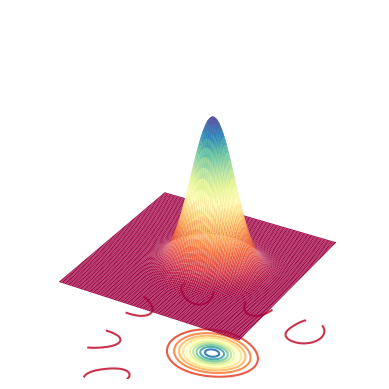

In [16]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.1)
ax.set_axis_off()
plt.savefig("T.png")
fig.show()

Learn

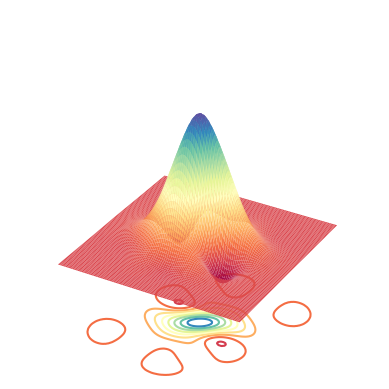

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.1) #0.2
ax.set_axis_off()
plt.savefig("L.png")
fig.show()

In [18]:
#Training state
ket

array([9.59887803e-01+0.00800701j, 0.00000000e+00-0.j        ,
       3.29112634e-02+0.24561198j, 0.00000000e+00-0.j        ,
       2.97423173e-02+0.09783239j, 0.00000000e+00-0.j        ,
       4.34989929e-02+0.01402228j, 0.00000000e+00-0.j        ,
       6.66557753e-04+0.00200279j])

In [19]:
#Quantum features map
QFM1

array([[9.41710616e-01+0.00000000e+00j, 3.07719176e-01-7.53694609e-17j,
        1.23150814e-01-6.03265000e-17j, 5.19515795e-02-3.81734013e-17j,
        2.24571622e-02-2.20016735e-17j, 9.84528344e-03-1.20569949e-17j,
        4.35598160e-03-6.40144671e-18j, 1.93975012e-03-3.32571229e-18j,
        8.67927640e-04-1.70064769e-18j]])